In [1]:
using GpABC, DifferentialEquations, Distances, Plots

# Rejection ABC using GaussProABC - estimating parameters

This notebook demonstrates how to perform simulation- and emulation-based rejection ABC using GaussProABC for parameter estimation of an ODE model.

Start by choosing some settings for ABC, the emulator and the toy, noise-free ODE system. There is also a wrapper function that returns the solution to the toy system for some given parameters and ODE solution options.

In [ ]:
#
# ABC settings
#
n_var_params = 3
n_particles = 1000
threshold = 0.5
priors = [Distributions.Uniform(0., 5.), Distributions.Uniform(0., 5.), Distributions.Uniform(0., 30.)]
priors = priors[1:n_var_params]
distance_metric = euclidean
progress_every = 10000

#
# Emulation settings
#
n_design_points = 100
batch_size = 1000
max_iter = 1000

#
# True parameters
#
true_params =  [2.0, 1.0, 15.0, 1.0, 1.0, 1.0, 100.0, 1.0, 1.0, 1.0]

#
# ODE solver settings
#
Tspan = (0.0, 10.0)
x0 = [3.0, 2.0, 1.0]
solver = RK4()
saveat = 0.1

#
# Returns the solution to the toy model as solved by DifferentialEquations
#
GeneReg = function(params::AbstractArray{Float64,1},
    Tspan::Tuple{Float64,Float64}, x0::AbstractArray{Float64,1},
    solver::OrdinaryDiffEq.OrdinaryDiffEqAlgorithm, saveat::Float64)

  if size(params,1) != 10
    throw(ArgumentError("GeneReg needs 10 parameters, $(size(params,1)) were provided"))
  end

  function ODE_3GeneReg(dx, x, par, t)
    dx[1] = par[1]/(1+par[7]*x[3]) - par[4]*x[1]
    dx[2] = par[2]*par[8]*x[1]./(1+par[8]*x[1]) - par[5]*x[2]
    dx[3] = par[3]*par[9]*x[1]*par[10]*x[2]./(1+par[9]*x[1])./(1+par[10]*x[2]) - par[6]*x[3]
  end

  prob = ODEProblem(ODE_3GeneReg, x0 ,Tspan, params)
  Obs = solve(prob, solver, saveat=saveat)

  return Obs
end

simulator_function(var_params) = GeneReg(vcat(var_params, true_params[n_var_params+1:end]), Tspan, x0, solver, saveat)

simulator_function (generic function with 1 method)

## Plot reference data

The reference data is the concentrations over time for the three species. Computed by solving the model with the true parameters.

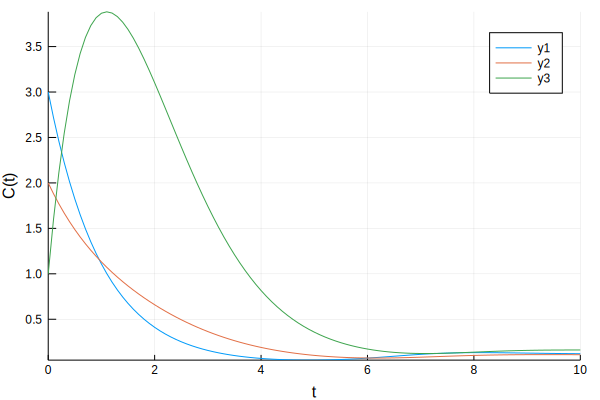

In [3]:
#
# Get reference data and plot it
#
reference_data = simulator_function(true_params[1:n_var_params])

println("Got reference data")
plot(reference_data.t, transpose(hcat(reference_data.u...)), xlabel="t", ylabel="C(t)")


## Simulation-based rejection ABC

To perform rejection ABC, first construct an instance of one of either two objects: `SimulatedABCRejectionInput` or `EmulatedABCRejectionInput`.

The simulated version contains the number of accepted particles, acceptance threshold, priors, the distance metric and the simulator funciton. Note that this needs to be extended to include summary statistics.

The simulator function is user-defined and must to take the unknown parameters as a single argument and return the simluated trajectories.

After constructing the input object it is passed to `ABCrejection` with the reference (observed) data to perform rejection ABC.

In [4]:
#
# Simulation
#


sim_rej_input = SimulatedABCRejectionInput(n_var_params,
                        n_particles,
                        threshold,
                        priors,
                        "keep_all",
                        distance_metric,
                        simulator_function)

sim_result = ABCrejection(sim_rej_input, reference_data, progress_every=progress_every)

2018-07-18T16:42:32.206 Accepted 9/10000 particles.
2018-07-18T16:42:33.266 Accepted 14/20000 particles.
2018-07-18T16:42:34.285 Accepted 16/30000 particles.
2018-07-18T16:42:35.305 Accepted 25/40000 particles.
2018-07-18T16:42:36.386 Accepted 28/50000 particles.
2018-07-18T16:42:37.445 Accepted 32/60000 particles.
2018-07-18T16:42:38.477 Accepted 38/70000 particles.
2018-07-18T16:42:39.495 Accepted 46/80000 particles.
2018-07-18T16:42:40.519 Accepted 52/90000 particles.
2018-07-18T16:42:41.548 Accepted 60/100000 particles.
2018-07-18T16:42:42.575 Accepted 72/110000 particles.
2018-07-18T16:42:43.614 Accepted 84/120000 particles.
2018-07-18T16:42:44.63 Accepted 93/130000 particles.
2018-07-18T16:42:45.645 Accepted 95/140000 particles.
2018-07-18T16:42:46.66 Accepted 100/150000 particles.
2018-07-18T16:42:47.676 Accepted 110/160000 particles.
2018-07-18T16:42:48.708 Accepted 117/170000 particles.
2018-07-18T16:42:49.727 Accepted 122/180000 particles.
2018-07-18T16:42:50.742 Accepted 127

GpABC.ABCRejectionOutput(3, 1000, 1421858, 0.5, [1.07251 0.966128 15.1635; 3.06608 1.01809 14.8999; … ; 1.63955 1.14734 15.0163; 1.65693 0.923221 15.4377], [0.434176, 0.396127, 0.297821, 0.394252, 0.477688, 0.471446, 0.302709, 0.0646, 0.495477, 0.457343  …  0.376225, 0.447194, 0.349085, 0.499628, 0.364698, 0.452947, 0.383996, 0.425294, 0.492473, 0.371083], [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001  …  0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001])

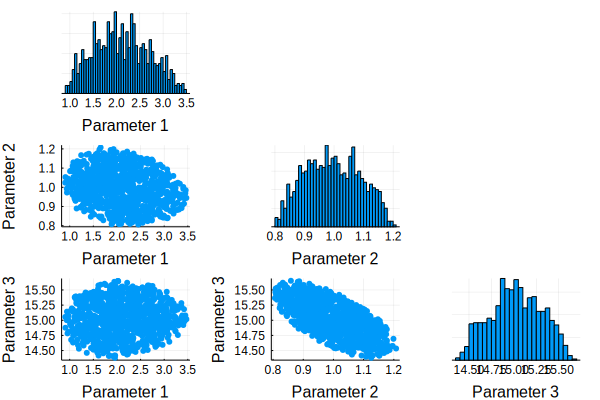

In [5]:
plot(sim_result)

## Emulation-based Rejection ABC

First train the emulator. This requires training inputs `X` and training outputs `y`, where `X` is an array with size (n_design_points, n_unknown_parameters) and `y` is an array with size (n_design_points).

The function `get_training_data` returns `X` and `y` in the correct format to be used with a `GPModel`.

Then train the model, plotting the design points and their distances.

Trained emulator


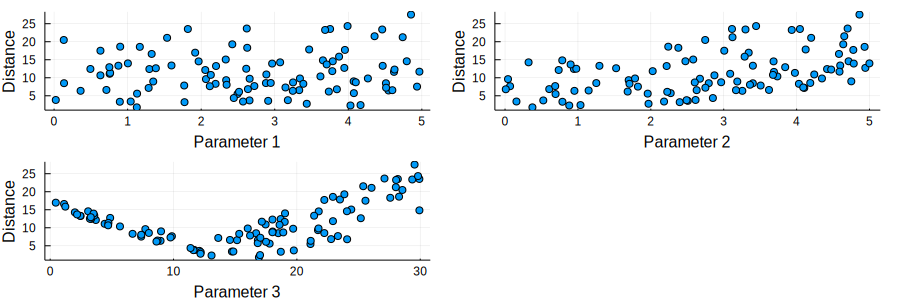

In [6]:
#
# Train the Emulator
#

#
# First prepare data for emulator - matrix X contains design ponts and y contains distances
#
function get_training_data(n_design_points,
  priors,
  simulator_function, distance_metric,
  reference_data)
    
  X = zeros(n_design_points, length(priors))
  y = zeros(n_design_points)  
  for i in 1:n_design_points
    dp = [rand(d) for d in priors]
    X[i,:] = dp
    y[i] = distance_metric(simulator_function(dp), reference_data)
  end
    
  return X, y
end

X, y = get_training_data(n_design_points, priors, simulator_function, distance_metric, reference_data)

#
# Train emulator - VARIANCE SEEMS SMALL
#
gpem = GPModel(training_x=X, training_y=y, kernel=SquaredExponentialArdKernel())
gp_train(gpem)

println("Trained emulator")

#
# Plot design points
#
plts = [scatter(X[:,idx], y, label="training data", xlabel="Parameter $idx", ylabel="Distance", legend=false) for idx = 1:n_var_params]
plot(plts..., size=(900, 300))

The second parameter is easier to pick up using this distance metric and summary statistic than the first.

When creating an `EmulatedABCRejectionInput` object provide a function that returns the emulated distances rather than the `simulator_function` required in the simulation case. Also provide a batch size and a maximum number of iterations.

In [22]:
#
# Use the emulator for rejection ABC
#
emu_result = EmulatedABCRejection(n_design_points, reference_data, n_particles, 1.0,
        priors, "keep_all", simulator_function,  progress_every=100)



2018-07-18T17:39:57.037 Accepted 0/1000000 particles (100 batches of size 10000).
2018-07-18T17:40:06.119 Accepted 0/2000000 particles (200 batches of size 10000).
2018-07-18T17:40:14.605 Accepted 0/3000000 particles (300 batches of size 10000).
2018-07-18T17:40:23.441 Accepted 0/4000000 particles (400 batches of size 10000).
2018-07-18T17:40:32.676 Accepted 0/5000000 particles (500 batches of size 10000).
2018-07-18T17:40:41.144 Accepted 0/6000000 particles (600 batches of size 10000).
2018-07-18T17:40:49.645 Accepted 0/7000000 particles (700 batches of size 10000).
2018-07-18T17:40:58.121 Accepted 0/8000000 particles (800 batches of size 10000).
2018-07-18T17:41:06.726 Accepted 0/9000000 particles (900 batches of size 10000).
2018-07-18T17:41:15.368 Accepted 0/10000000 particles (1000 batches of size 10000).


GpABC.ABCRejectionOutput(3, 0, 10000000, 1.0, [0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001  …  0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001])

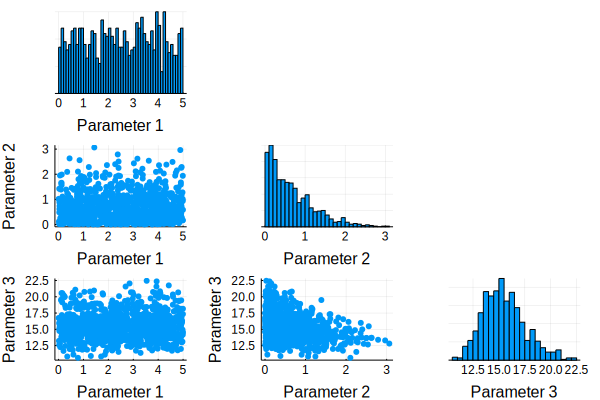

In [18]:
plot(emu_result)

# Comparing the resulting posteriors from simulation and emulation

They are similar and both center on the correct parameter values.

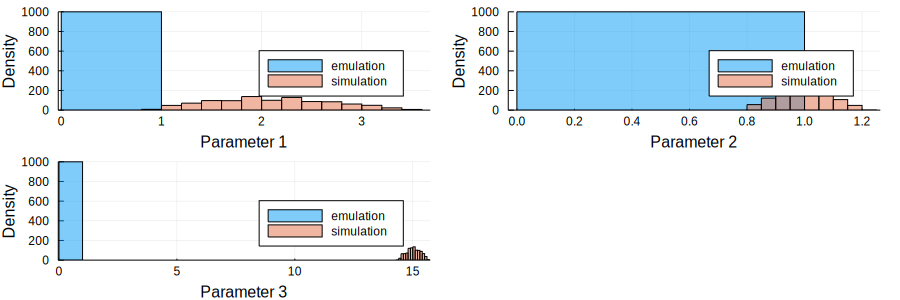

In [9]:
plts = Vector{Plots.Plot}(n_var_params)
for idx in 1:n_var_params
    plts[idx] = histogram([emu_result.population[:,idx] sim_result.population[:,idx]], 
        label=["emulation", "simulation"], fillalpha=0.5, xlabel="Parameter $idx", ylabel="Density")
end
plot(plts..., size=(900,300))

# ABC-SMC

In [ ]:
#
# ABC-SMC settings
#
threshold_schedule = [3.0, 2.0, 1.0]

3-element Array{Float64,1}:
 3.0
 2.0
 1.0

## Simulation-based ABC-SMC

In [11]:
sim_abcsmc_input = SimulatedABCSMCInput(n_var_params,
    n_particles,
    threshold_schedule,
    priors,
    "keep_all",
    distance_metric,
    simulator_function)

sim_abcsmc_res = ABCSMC(sim_abcsmc_input, reference_data)

2018-07-18T16:46:50.423 Accepted 62/1000 particles.
2018-07-18T16:46:50.537 Accepted 125/2000 particles.
2018-07-18T16:46:50.646 Accepted 178/3000 particles.
2018-07-18T16:46:50.753 Accepted 250/4000 particles.
2018-07-18T16:46:50.856 Accepted 308/5000 particles.
2018-07-18T16:46:50.964 Accepted 379/6000 particles.
2018-07-18T16:46:51.071 Accepted 441/7000 particles.
2018-07-18T16:46:51.179 Accepted 505/8000 particles.
2018-07-18T16:46:51.286 Accepted 578/9000 particles.
2018-07-18T16:46:51.39 Accepted 646/10000 particles.
2018-07-18T16:46:51.497 Accepted 705/11000 particles.
2018-07-18T16:46:51.604 Accepted 770/12000 particles.
2018-07-18T16:46:51.712 Accepted 832/13000 particles.
2018-07-18T16:46:51.819 Accepted 888/14000 particles.
2018-07-18T16:46:51.923 Accepted 963/15000 particles.
2018-07-18T16:46:53.414 Accepted 133/1000 particles.
2018-07-18T16:46:54.055 Accepted 238/2000 particles.
2018-07-18T16:46:54.723 Accepted 367/3000 particles.
2018-07-18T16:46:55.391 Accepted 487/4000 

GpABC.ABCSMCOutput(3, [1000, 1000, 1000], [15718, 8141, 8533], [3.0, 2.0, 1.0], AbstractArray{Float64,2}[[2.50245 1.15256 14.6814; 3.4926 2.07928 13.127; … ; 4.79844 0.85468 17.5919; 1.80977 1.07988 12.6855], [0.325424 1.22419 15.6652; 1.83876 1.3159 15.4764; … ; 4.49329 0.383005 17.538; 4.60477 1.12166 15.6774], [2.2518 1.39491 14.1354; 3.50646 0.863265 14.5418; … ; 2.12461 1.01281 15.3543; 1.66755 0.674496 15.8925]], AbstractArray{Float64,1}[[0.454916, 2.68697, 2.0399, 2.79191, 1.03706, 2.39187, 2.6164, 2.93016, 2.86358, 2.9978  …  2.24603, 2.14593, 2.90792, 2.88441, 1.11055, 2.70058, 2.04929, 1.58169, 2.58669, 2.30737], [1.51226, 1.42239, 1.82636, 1.77103, 1.15438, 1.51066, 1.9744, 0.976119, 1.54107, 0.380801  …  1.70812, 1.93834, 1.03257, 1.98596, 1.51758, 1.36314, 0.640605, 1.51537, 1.97073, 1.4751], [0.974951, 0.92983, 0.155949, 0.764642, 0.766599, 0.3226, 0.582083, 0.793401, 0.702499, 0.964976  …  0.923119, 0.536528, 0.826342, 0.828599, 0.727956, 0.69047, 0.673782, 0.847069, 0.4

In [ ]:
plot(sim_abcsmc_res)

## Emulation-based ABC-SMC

In [13]:
emu_abcsmc_res = EmulatedABCSMC(n_design_points, reference_data, n_particles, threshold_schedule,
        priors, "keep_all", simulator_function)



2018-07-18T16:47:08.473 Accepted 306/1000 particles.
2018-07-18T16:47:09.521 Accepted 17/1000 particles.


GpABC.ABCSMCOutput(3, [1000, 306, 17], [20000, 1000, 1000], [3.0, 2.0, 1.0], AbstractArray{Float64,2}[[2.82476 0.618383 13.326; 0.251208 0.699938 13.7758; … ; 4.37024 0.901027 15.3127; 3.34144 0.979679 17.0358], [2.98502 0.570154 14.5868; 3.62542 0.445662 15.5536; … ; 0.0 0.0 0.0; 0.0 0.0 0.0], [3.81114 1.0777 15.4259; 2.92605 1.05271 14.3489; … ; 0.0 0.0 0.0; 0.0 0.0 0.0]], AbstractArray{Float64,1}[[2.5119, 2.18025, 2.81497, 2.03604, 2.87862, 1.50627, 1.76032, 2.96928, 2.80103, 2.3093  …  2.21425, 2.24609, 1.33361, 2.58723, 2.99005, 2.45422, 2.64174, 1.84469, 1.08244, 1.98841], [1.74715, 1.68346, 0.978881, 1.44219, 0.717239, 1.85646, 1.72447, 1.0501, 1.22826, 1.91276  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.941449, 0.98025, 0.831196, 0.83084, 0.982558, 0.927873, 0.846737, 0.906734, 0.855123, 0.93802  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], StatsBase.Weights[[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001  …  0.001, 0.001, 0.001, 0.

In [ ]:
plot(emu_abcsmc_res, markerstrokecolor=false)

## Compare the posteriors

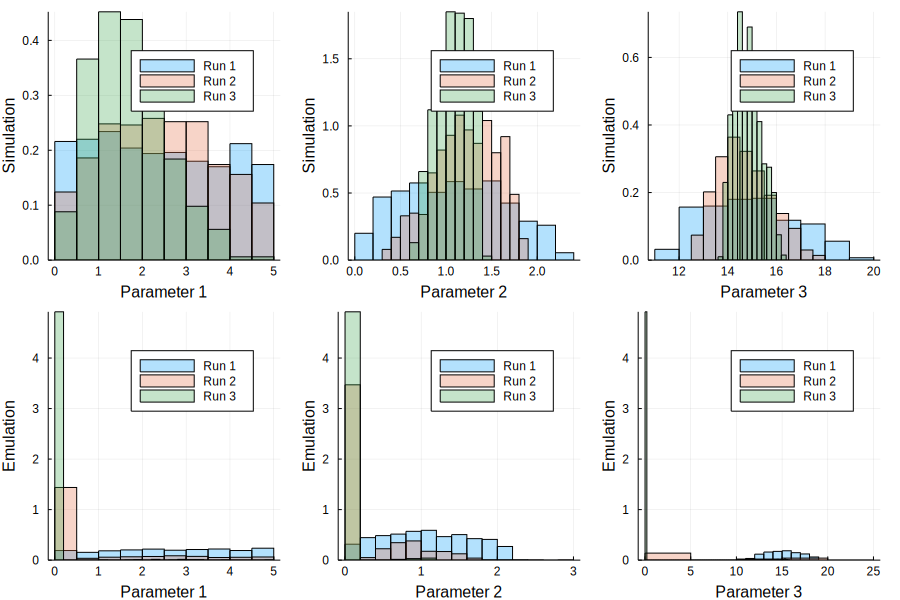

In [15]:
abcsmc_res = [sim_abcsmc_res, emu_abcsmc_res]
ylabels=["Simulation", "Emulation"]
plts = Vector{Plots.Plot}(n_var_params * 2)
idx = 1
for i in 1:2
    for j in 1:n_var_params
        hist_data = hcat([abcsmc_res[i].population[k][:,j] for k in 1:length(threshold_schedule)]...)
        labels = ["Run $k" for k in 1:length(threshold_schedule)]
        plts[idx] = histogram(hist_data, label=labels, fillalpha=0.3, 
            xlabel="Parameter $j", ylabel=ylabels[i], normed=true)
        idx += 1
    end
end
plot(plts..., size=(900,600))


In [16]:
size(abcsmc_res[1].population[end])

(1000, 3)